In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
## Loading the admissions prediction dataset

raw_data = pd.read_csv('Admission_Predict.csv').set_index('Serial No.', drop=True)
raw_data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
## Isolating the predictors and response variable

X = raw_data.iloc[:,:-1]
y = raw_data.iloc[:,-1]

In [4]:
## Splitting data into training and testing sets

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

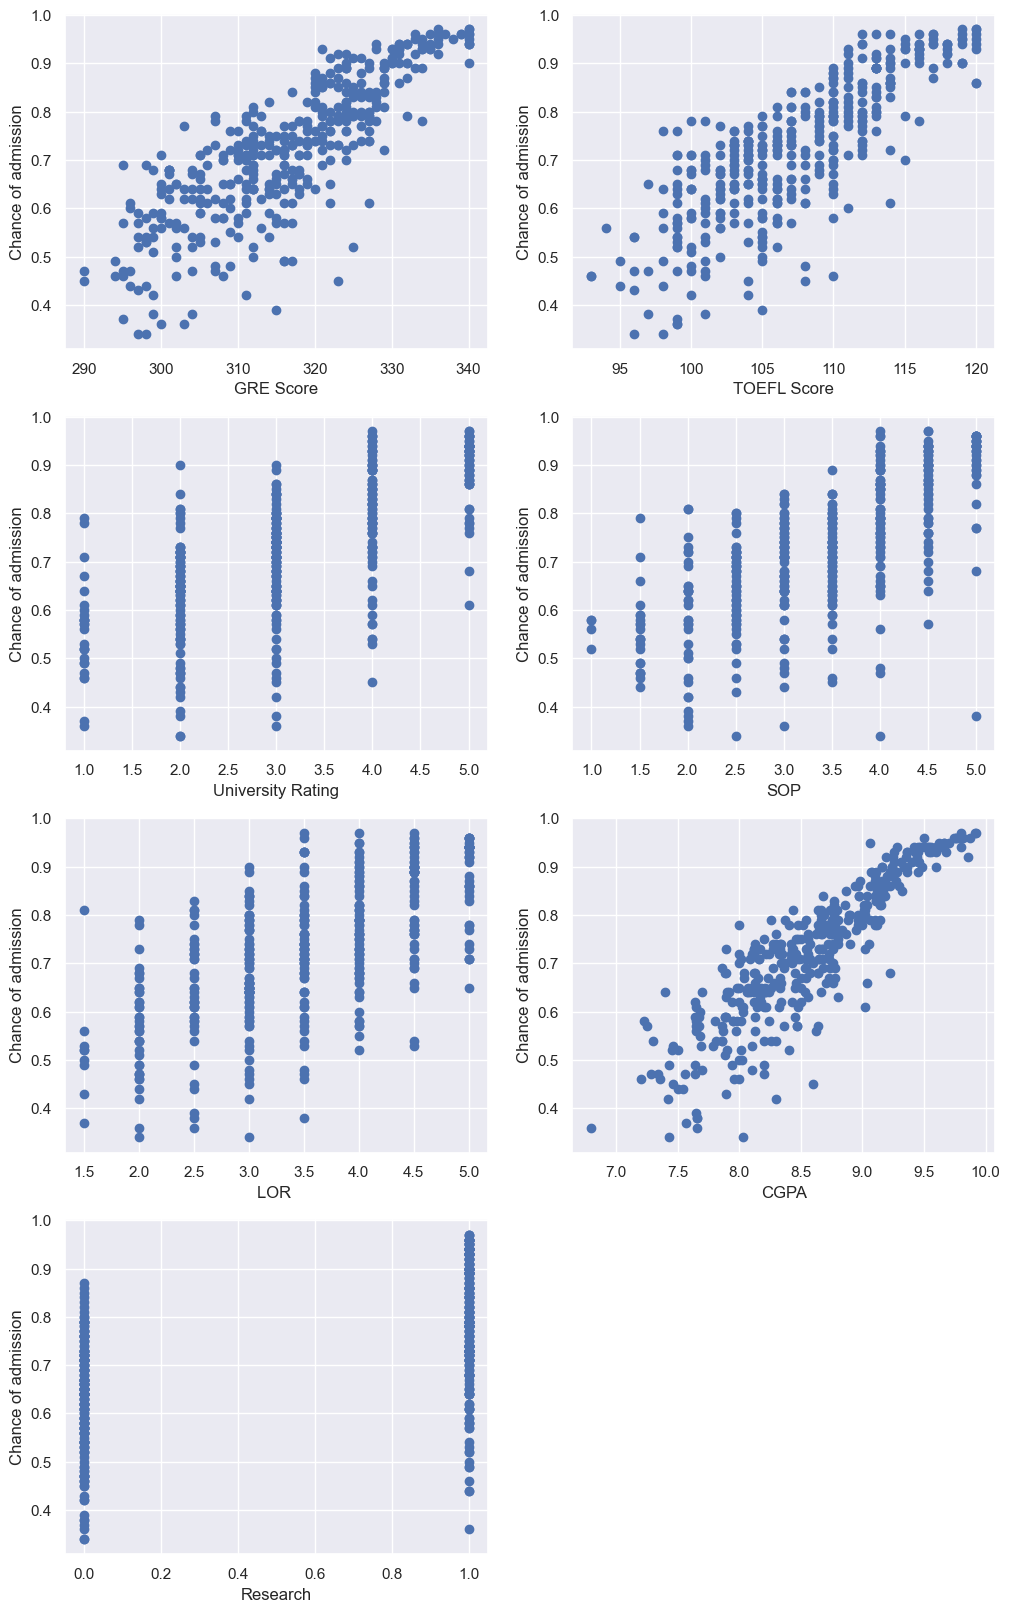

In [5]:
## Visualizing the relationship between each predictor and the response variable

fig, ax = plt.subplots(4,2, figsize=(12,20))

for r in range(4):
    for c in range(2):
        i = r*2 + c
        if i == 7:
            ax[r,c].axis('off')
        else:
            ax[r,c].scatter(xtrain.iloc[:,i],ytrain)
            ax[r,c].set_xlabel(xtrain.columns[i])
            ax[r,c].set_ylabel("Chance of admission")
plt.show()

In [6]:
## Fitting a full linear regression model based on the linear relationships shown above
## Calculating the residuals for the model

from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(xtrain, ytrain)
lr_residuals = ytrain - lr.predict(xtrain)

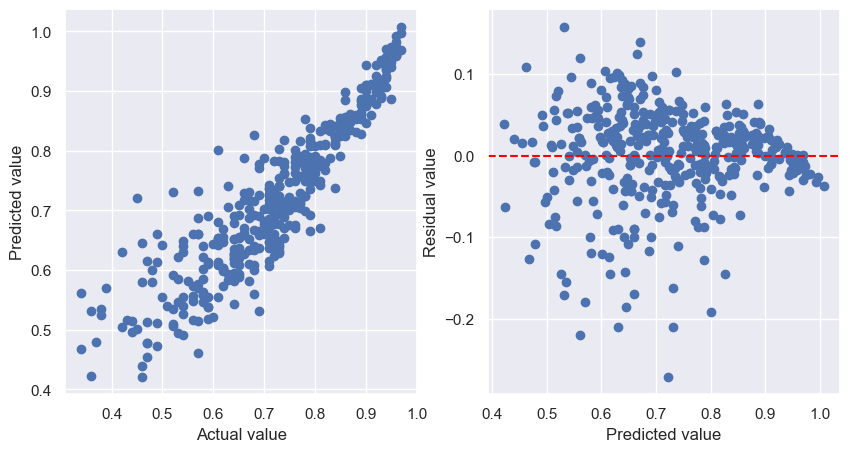

In [7]:
## Checking the linearity and constant variance assumptions

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(ytrain, lr.predict(xtrain))
ax[0].set_xlabel("Actual value")
ax[0].set_ylabel("Predicted value")

ax[1].scatter(lr.predict(xtrain), lr_residuals)
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("Residual value")

plt.show()

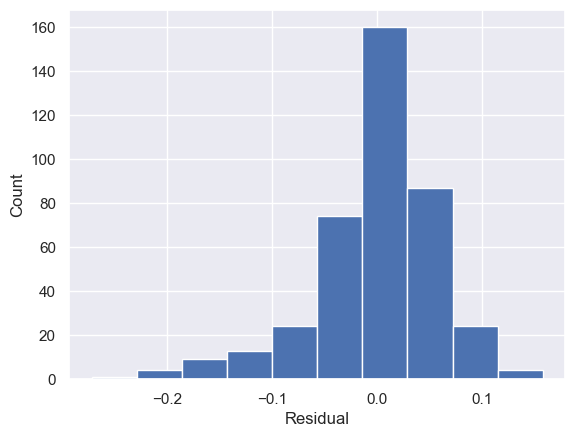

In [17]:
## Checking the normality assumption

plt.hist(lr_residuals)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

In [8]:
## All graphs appear to show slight deviance from each assumption.
## 
## Testing colinearity between the predictors using variance inflaction factor

from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({"Predictor": xtrain.columns, "VIF": [variance_inflation_factor(np.array(xtrain), i) for i in range(7)]})

,Predictor,VIF
0,GRE Score,1290.385023
1,TOEFL Score,1255.655728
2,University Rating,23.205129
3,SOP,36.448410
4,LOR,32.144863
5,CGPA,940.325012
6,Research,2.928328


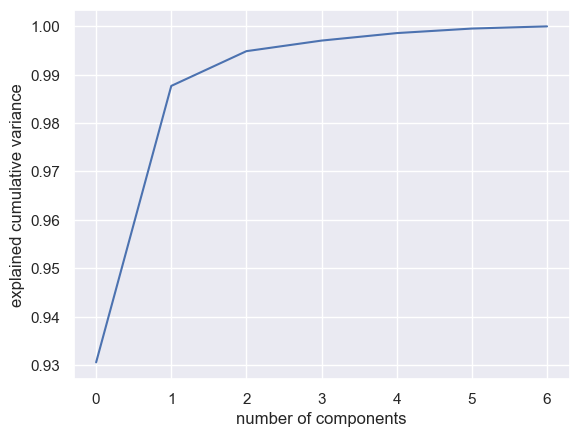

In [9]:
## VIF values are high, showing much colinearity. Variable selection is needed to prevent overfitting.
## PCA will be used to reduce the dimensionality

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(xtrain)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained cumulative variance');

In [10]:
## The first principal component explains almost 99% of the variance.
## We will use only the first PC due to its high explanatory power.

Xpca = pca.fit_transform(xtrain)[:,0].reshape(400,1)

pcalr = LinearRegression().fit(Xpca, ytrain)

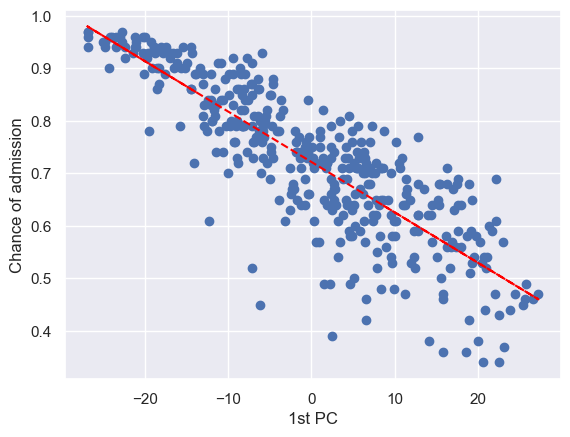

In [11]:
## Plotting the regression line versus the 1st principal component

plt.plot(Xpca, pcalr.predict(Xpca), color="red", linestyle="--")
plt.scatter(Xpca,ytrain)
plt.xlabel("1st PC")
plt.ylabel("Chance of admission")
plt.show()

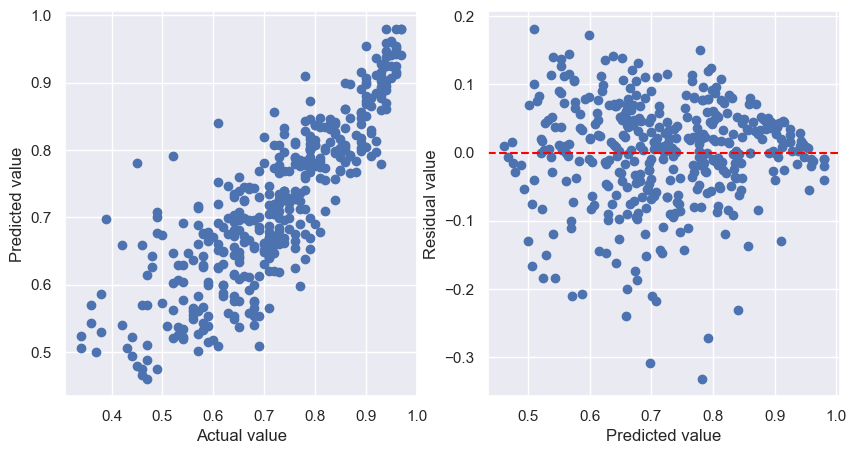

In [12]:
## Checking the linearity and constant variance assumptions

pcalr_residuals = ytrain - pcalr.predict(Xpca)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(ytrain, pcalr.predict(Xpca))
ax[0].set_xlabel("Actual value")
ax[0].set_ylabel("Predicted value")

ax[1].scatter(pcalr.predict(Xpca), pcalr_residuals)
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("Residual value")

plt.show()

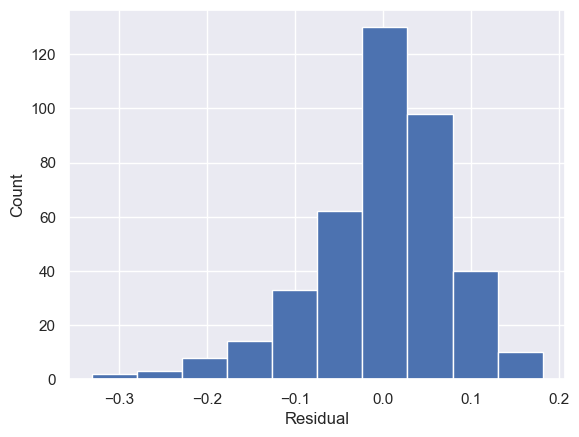

In [13]:
## Checking the normality assumption of residuals. The graph is skewed but fairly normally distributed.

plt.hist(pcalr_residuals)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

In [14]:
## Calculating the MSE of the full linear regression model

lr_training_MSE = np.mean((lr.predict(xtrain) - ytrain)**2)

lr_mse = np.mean((lr.predict(xtest) - ytest)**2)

print("Linear Regression Training MSE: {}".format(lr_training_MSE))
print("Linear Regression Test MSE: {}".format(lr_mse))

Linear Regression Training MSE: 0.0034672591678945063
Linear Regression Test MSE: 0.0039496406120443864


In [15]:
## Calculating the mean squared error for the fitted model on the training and testing data.

pcalr_training_MSE = np.mean((pcalr.predict(Xpca) - ytrain)**2)

pcalr_pred = pcalr.predict(pca.transform(xtest)[:,0].reshape(100,1))
pcalr_mse = np.mean((pcalr_pred - ytest)**2)

print("PCA Linear Regression Training MSE: {}".format(pcalr_training_MSE))
print("PCA Linear Regression Test MSE: {}".format(pcalr_mse))

PCA Linear Regression Training MSE: 0.005907414882218405
PCA Linear Regression Test MSE: 0.0069107397284365515


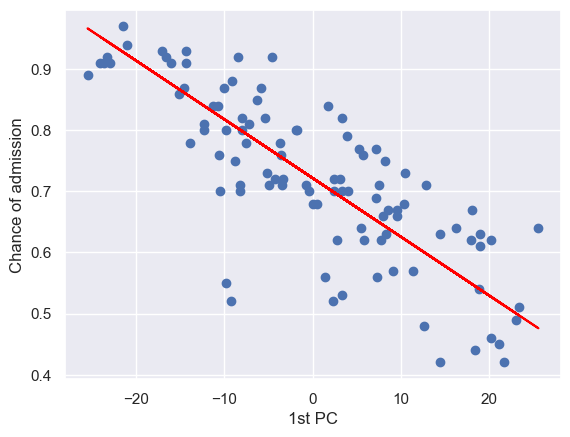

In [16]:
## Plotting the predicted test values versus the actual test values

plt.plot(pca.transform(xtest)[:,0].reshape(100,1), pcalr_pred, color="red")
plt.scatter(pca.transform(xtest)[:,0].reshape(100,1), ytest)
plt.xlabel("1st PC")
plt.ylabel("Chance of admission")
plt.show()

Although the full linear regression model gives a lower MSE, this model does not pass the assumptions of linear regression and is a poor fit. Reducing the dimensionality with PCA provides a better fitted model with similar predictive power.